# Music Streaming Royalty Analysis
### Introduction
How much does a musical artist get paid per stream? That may seem like a simple question but you'll soon see that it is not. The answer depends on when the stream occurred, what type of subscription the person has, where they're located, and what streaming service they use. That last bit of information will be the primary focus of this project. I use real (somewhat anonymized) data from my own former band's royalty statements which includes data for over 800,000 streams from that past few years to better understand just how much money streaming services pay and how much this varies by streaming service.

This project showcases:
- **Non-parametric hypothesis tests:** Using a Kruskal-Wallis test with post-hoc analysis, I demonstrate how to test the significance in the medians of groups with non-normal distributions.
- **Effect size reporting:** Sometimes a p-value is not enough. I include effect sizes when discussing differences between groups to better contexualize the significance of the findings.
- **Group visualization:** I show how to effectively visualize data from different groups in order to facilitate comparisons including box plots, violin plots, pie charts, and time-series plots.

### Import data
I first start by importing the cleaned and anonymized data.
A few notes about data cleaning:
- All album sales were removed so the data only contains information about streaming
- Some streaming services differentiated between subscription type (i.e. free versus premium), however, not all services did, so all data was aggregated together in each service regardless of subscription type.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

df = pd.read_csv('royalties_cleaned.csv')
df['Sales Date'] = df['Sales Date'].astype('datetime64[ns]')
df.round(5).head()

,Sales Date,Quantity,Price,Subtotal,Album Name,Track Name,Partner Name,Transaction Type,Delivery Country
0,2017-08-15,7,0.00077,0.00541,Album_1,Track_1_1,Pandora,Stream,US
1,2017-08-15,1,0.00077,0.00077,Album_1,Track_1_2,Pandora,Stream,US
2,2017-08-15,2,0.00077,0.00155,Album_1,Track_1_3,Pandora,Stream,US
3,2017-08-15,40,0.00077,0.03094,Album_1,Track_1_4,Pandora,Stream,US
4,2017-08-15,36,0.00077,0.02785,Album_1,Track_1_5,Pandora,Stream,US


### Top streaming services
In order to compare the payments of different streaming services it is important to know which are the top services. Below is a pie chart showing the proportion of streams per service.

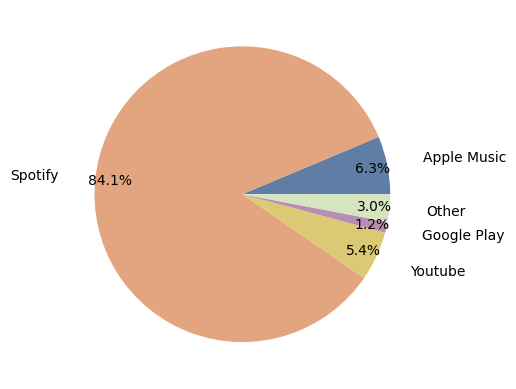

In [2]:
# Define plotting colors
blue = '#5F7DA5'
orange = '#E3A580'
gold = '#DCC973'
purple = '#BA8EB2'
green = '#D4E5BF'
colors = [blue, orange, gold, purple, green]

# Get total streams from each service
partners = df['Partner Name'].unique()
plays = []
for partner in partners:
    plays.append(sum(df[df['Partner Name'] == partner].Quantity))    
plays.sort(reverse=True)

# Get top four services
thresh = plays[3]
plays_dict = {}
for partner in partners:
    cur_plays = sum(df[df['Partner Name'] == partner].Quantity)
    if cur_plays >= thresh:
        plays_dict[partner] = cur_plays

# Create "other" category
rest = sum(plays[4:])
plays_dict['Other'] = rest

# Create pie chart
plt.pie(plays_dict.values(), labels=plays_dict.keys(), autopct='%1.1f%%',
       pctdistance=0.9, labeldistance=1.25, colors=colors)
#plt.savefig("pie_chart.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

As expected, the most streams are coming from Spotify, by far. Apple Music, Youtube, and Google Play are a distant 2nd, 3rd, and 4th, respectively.

Let's look at total number of streams overall and total number of streams from each service below.

In [3]:
# Get list of top 4 streaming services
top_partners = list(plays_dict.keys())
top_partners.remove('Other')

print("Total streams from all streaming services: " + str(sum(df.Quantity.values)))

for partner in top_partners:
    total_streams = sum(df[df['Partner Name']==partner].Quantity.values)
    print("\n" + partner + " total streams: " + str(total_streams))

Total streams from all streaming services: 882603

Apple Music total streams: 55864

Spotify total streams: 742068

Youtube total streams: 47643

Google Play total streams: 10512


### Histograms of per-stream payments
Let's look at the distribution of per-stream royalty payments of the top two streaming services.

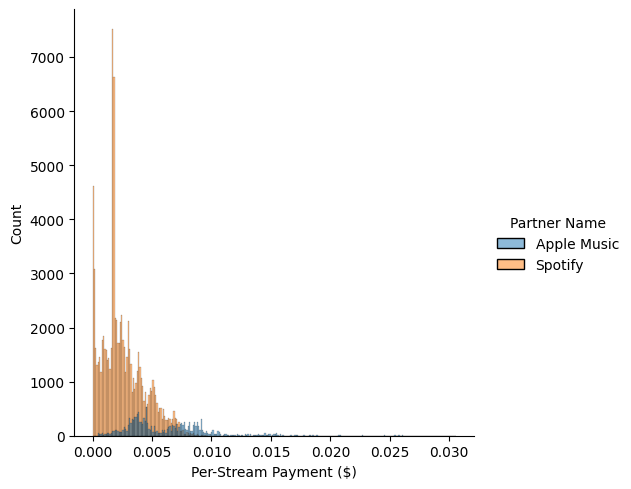

In [5]:
# Histograms of top two services
apple_spotify = df[(df['Partner Name']=='Apple Music') | (df['Partner Name']=='Spotify')]
sns.displot(data=apple_spotify, x='Price', hue='Partner Name', color=colors[:2])
plt.xlabel('Per-Stream Payment ($)')
#plt.savefig("spotify_apple_hist.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

Some takeaways from these histograms:
- The distributions are not normal, so any investigation into the difference should use a non-parametric test
- While Apple has contributed fewer streams overall, it appears to pay more per-stream than spotify

Let's look at the data in a few other ways.

### Violin plots and box plots of per-stream payments

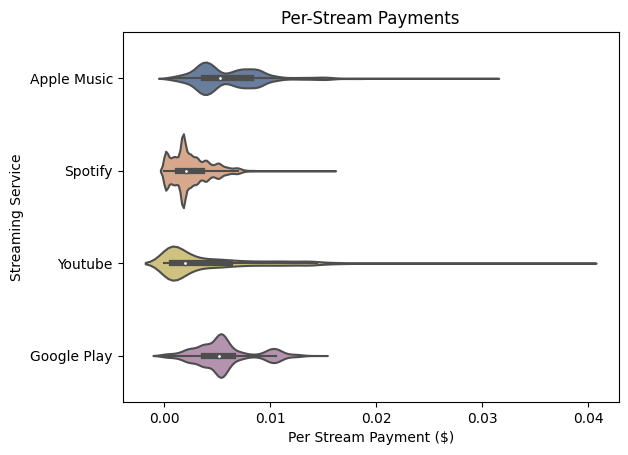

In [6]:
# Violin plots of top services
sns.violinplot(data=df[df['Partner Name'].isin(top_partners)],
               x='Price', y='Partner Name', palette=colors)
plt.title('Per-Stream Payments')
plt.xlabel('Per Stream Payment ($)')
plt.ylabel('Streaming Service')
plt.savefig("violin_plots.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

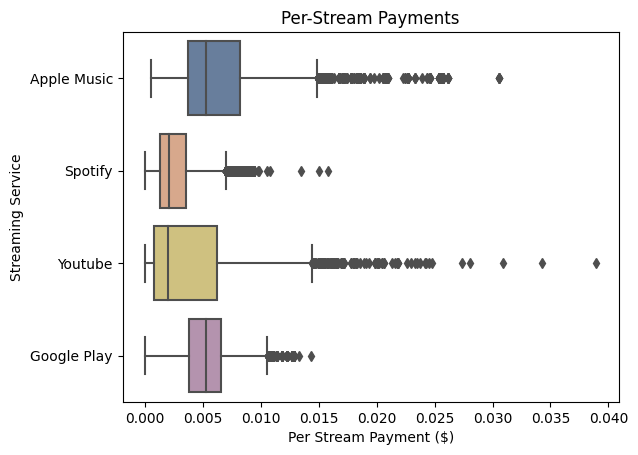

In [7]:
# Box plots of top services
sns.boxplot(data=df[df['Partner Name'].isin(top_partners)],
               x='Price', y='Partner Name', palette=colors)
plt.title('Per-Stream Payments')
plt.xlabel('Per Stream Payment ($)')
plt.ylabel('Streaming Service')
plt.savefig("box_plots.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

This shows a little more clearly the difference in the per-stream payouts of the different streaming services. It looks like spotify and youtube are the worst while Apple and Google are a little better. Let's look at their median payment-per-stream amounts below.

In [8]:
for service in top_partners:
    sub_df = df[df['Partner Name']==service]
    print("Median " + service + " per-stream payment: " + str(round(np.median(sub_df.Price), 5)))

Median Apple Music per-stream payment: 0.00529
Median Spotify per-stream payment: 0.00203
Median Youtube per-stream payment: 0.00196
Median Google Play per-stream payment: 0.00521


We can see that Apple and Google both pay around half a cent per stream while both Spotify and Youtube pay around one-fifth of a penny per play.

But are these differences significant?

### Test significance of royalty payment difference

In [9]:
import scikit_posthocs as sp

# Test significance between payment differences of
price_list = [group['Price'].values for partner, group in df.groupby('Partner Name') if partner in top_partners]

# Conduct kruskal-wallis test
statistic, p = stats.kruskal(*price_list)
print("Kruskal-Wallis test p-value: ", p)

# Post-hoc analysis using holm-bonferroni correction
ph = sp.posthoc_dunn(df[df['Partner Name'].isin(top_partners)], 
                    val_col='Price', group_col='Partner Name', p_adjust='holm')

ph.round(5)

Kruskal-Wallis test p-value:  0.0


,Apple Music,Google Play,Spotify,Youtube
Apple Music,1.00000,0.00024,0.0,0.0
Google Play,0.00024,1.00000,0.0,0.0
Spotify,0.00000,0.00000,1.0,0.0
Youtube,0.00000,0.00000,0.0,1.0


The Kruskal-Wallis test tells us that there is a significant difference between the groups since the p-value is functionally 0. A post hoc pairwise test was performed to better understand the significance of the differences between each streaming service. The output table shows us that there is a significant different between each pairwise comparison.

This may seem surprising at first, considering the box plots and medians above show pretty similar values between Apple and Google as well as between Spotify and Youtube. However, because the sample sizes are so high for each of these services (in the tens or hundreds of thousands), tiny p-values can result even for very small effect sizes.

To better understand the differences between these services, I examine the effect sizes below.

### Effect size

In [15]:
# Calculate effect size using Cliff's Delta
from cliffs_delta import cliffs_delta
d, res = [], []
for partner1 in top_partners:
    for partner2 in top_partners:
        x1 = df[df['Partner Name']==partner1].Price.values
        x2 = df[df['Partner Name']==partner2].Price.values
        cur_d, cur_res = cliffs_delta(x1, x2)
        d.append(cur_d)
        res.append(cur_res)
        
d = np.array(d).reshape(4, 4)

df_d = pd.DataFrame(d, index=top_partners, columns=top_partners)

df_d.round(2)

,Apple Music,Spotify,Youtube,Google Play
Apple Music,0.00,0.71,0.43,0.05
Spotify,-0.71,0.00,-0.04,-0.67
Youtube,-0.43,0.04,0.00,-0.39
Google Play,-0.05,0.67,0.39,0.00


To test the effect size of these differences, I used Cliff's delta since the data has a non-normal distribution and this test does not require any assumptions about the distribution of the data. The output is a value between -1 and +1.

The resulting effect sizes give a better measure of how different the per-stream payments are between the different services. You can see that the effect size between Apple and Spotify is large (\~0.71) while the effect size between Spotify and Youtube is very small (\~0.04).

A description of the effect size (also output by the `cliffs_delta` function) can be seen in the table below.

In [11]:
res = np.array(res).reshape(4, 4)
df_res = pd.DataFrame(res, index=top_partners, columns=top_partners)
df_res

,Apple Music,Spotify,Youtube,Google Play
Apple Music,negligible,large,medium,negligible
Spotify,large,negligible,negligible,large
Youtube,medium,negligible,negligible,medium
Google Play,negligible,large,medium,negligible


### Per-stream payment over time
Since there seems to be a lot of variability in the per-stream payment, it might be interesting to see how this metric has varied over time for each service.

In [12]:
# Set sales_date as index
df.set_index('Sales Date', inplace=True)

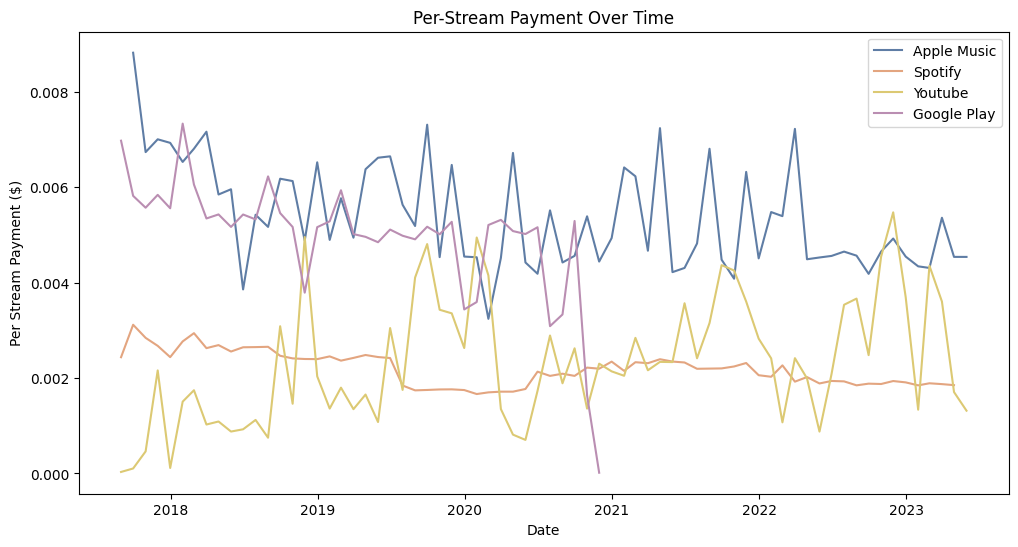

In [14]:
# Resample as monthly then replot the time-series data from above
plt.figure(figsize=(12, 6))
for color, partner in zip(colors, top_partners):
    cur_df = df[df['Partner Name']==partner]
    grouped_data = cur_df.groupby(pd.Grouper(freq='M'))
    plt.plot(grouped_data.Price.median(), label=partner, color=color)

plt.title('Per-Stream Payment Over Time')
plt.xlabel('Date')
plt.ylabel('Per Stream Payment ($)')
plt.legend(loc='best')
#plt.savefig("stream_time_series.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

This reinforces the earlier conclusions that Apple Music and Google Play tend to pay more per stream than Youtube and Spotify. (Note that the Google Play service was terminated in December 2020, hence the lack of data after that date.)

Something that this chart shows that wasn't quite as clear in previous figures is that Spotify shows the least month-to-month variability in how much it pays per stream.

### Conclusion
While this data does support the conclusion that Spotify pays artists less per stream than Apple Music does, there are things this data does not show. For example, the amount a stream pays depends on a lot of variables including subscription type. Free subscriptions, student subscriptions, family subscriptions, and premium subscriptions all pay different amounts. The data did not distinguish among these different subscriptions for every service, so they were grouped together. While Apple Music offers a limited free trial, it does not have a long-term free subscription tier. This alone could account for some of the streaming payment differences between these two services. However, without additional data on account types, it is impossible to say to what degree.

One other point worth noting is that Spotify has made commitments with major music labels to pay them a minimum amount, regardless of how many streams their respective catalogues actually garner. Considering [the most recent commited payments amount to over \$4 billion](https://d18rn0p25nwr6d.cloudfront.net/CIK-0001639920/1eb37b78-b453-4891-935f-52c06e4ea670.pdf) in the next two years, and that Spotify's revenue for the year 2022 was [\$12.3 billion](https://www.macrotrends.net/stocks/charts/SPOT/spotify-technology/revenue#:~:text=Spotify%20Technology%20revenue%20for%20the%20twelve%20months%20ending%20June%2030,a%2027.07%25%20increase%20from%202020.),
this is almost certain to have a negative impact on the streaming payments of those artists who do not have the support of major labels.

One last point to make is that even if a streaming service pays more than other, it doesn't mean this amount is fair.  Groups like the [Union of Musicians and Allied Workers](https://weareumaw.org/) are calling for, among other things, a minimum payment of one cent per stream. This would require an 89\% increase in payment from Apple Music and an almost 400\% increase from Spotify.